In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
print("✅ All packages successfully imported!")


✅ All packages successfully imported!


In [9]:
pollution_dataset = pd.read_csv('pollution_2000_2023.csv')

# removed Nans
pollution_dataset = pollution_dataset.dropna()

#Converting Date to datetime
pollution_dataset["Date"] = pd.to_datetime(pollution_dataset["Date"])

#Converting  Address columns  to Strings
pollution_dataset["Address"] = pollution_dataset["Address"].astype('string')
pollution_dataset["State"] = pollution_dataset["State"].astype('string')
pollution_dataset["County"] = pollution_dataset["County"].astype('string')
pollution_dataset["City"] = pollution_dataset["City"].astype('string')

#Converting the Max Hour of Pollutants to categorical variables
pollution_dataset["O3 1st Max Hour"] = pd.Categorical(pollution_dataset['O3 1st Max Hour'], categories=range(24))
pollution_dataset["CO 1st Max Hour"] = pd.Categorical(pollution_dataset['CO 1st Max Hour'], categories=range(24))
pollution_dataset["SO2 1st Max Hour"] = pd.Categorical(pollution_dataset['CO 1st Max Hour'], categories=range(24))
pollution_dataset["NO2 1st Max Hour"] = pd.Categorical(pollution_dataset['NO2 1st Max Hour'], categories=range(24))

#Converting AQI variables to Integer since that's what they are always reported as, and 2/4 were already int types
pollution_dataset["CO AQI"] = pollution_dataset["CO AQI"].astype(int)
pollution_dataset["SO2 AQI"] = pollution_dataset["SO2 AQI"].astype(int)

In [10]:
pollution_dataset

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,...,23,25,3.000000,9.0,23,13,19.041667,49.0,19,46
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,...,0,26,1.958333,3.0,0,4,22.958333,36.0,19,34
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,...,8,28,5.250000,11.0,8,16,38.125000,51.0,8,48
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,...,23,34,7.083333,16.0,23,23,40.260870,74.0,8,72
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,...,2,42,8.708333,15.0,2,21,48.450000,61.0,22,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665409,665409,2023-06-26,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Cheyenne,0.043941,0.050,12,46,...,0,0,0.117391,0.3,0,0,2.282609,4.3,6,4
665410,665410,2023-06-27,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Cheyenne,0.046235,0.054,12,50,...,0,0,0.091667,0.2,0,0,2.283333,5.2,6,5
665411,665411,2023-06-28,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Cheyenne,0.046588,0.055,7,51,...,0,0,0.091667,0.2,0,0,2.487500,4.8,19,4
665412,665412,2023-06-29,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Cheyenne,0.048765,0.056,9,54,...,0,0,0.052174,0.1,0,0,2.086957,4.1,8,4


In [11]:
#Heat map showing mean concentration of each pollutant by state
mean_pollutant_cols=['O3 Mean','CO Mean','SO2 Mean','NO2 Mean']
avg_pollutant_state =pollution_dataset.groupby('State')[mean_pollutant_cols].mean().reset_index()
avg_pollutant_state

#Plotly expects state abbreviations, which is why we have to map States
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT',
    'Delaware': 'DE','District Of Columbia':'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI',
    'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
    'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

avg_pollutant_state['State Code']=avg_pollutant_state['State'].map(state_abbrev)

for i in mean_pollutant_cols:
  fig = px.choropleth(
      avg_pollutant_state,
      locations='State Code',
      locationmode='USA-states',
      color=i,
      color_continuous_scale='Reds',
      scope='usa',
      labels={i: f'{i} Concentration'},
      title = f'Average {i} Concentration By State'
  )

  fig.show()


In [12]:
#scaling continous variables
scaler = StandardScaler()
scale_cols = ['O3 Mean','O3 1st Max Value','CO Mean', 'CO 1st Max Value', 'SO2 Mean','SO2 1st Max Value','NO2 Mean', 'NO2 1st Max Value']
pollution_dataset[scale_cols] = scaler.fit_transform(pollution_dataset[scale_cols])

In [13]:
# Add temporal features from Date
pollution_dataset['Year'] = pollution_dataset['Date'].dt.year
pollution_dataset['Month'] = pollution_dataset['Date'].dt.month
pollution_dataset['Day'] = pollution_dataset['Date'].dt.day
pollution_dataset['DayOfWeek'] = pollution_dataset['Date'].dt.dayofweek
pollution_dataset['IsWeekend'] = pollution_dataset['DayOfWeek'].isin([5, 6]).astype(int)
pollution_dataset['IsWedThur'] = pollution_dataset['DayOfWeek'].isin([2, 3]).astype(int)

# Create pollution level aggregates
pollution_dataset['Pollution_Avg'] = pollution_dataset[[
    'O3 Mean','CO Mean','SO2 Mean','NO2 Mean'
]].mean(axis=1)

# Lag features
pollution_dataset = pollution_dataset.sort_values(['City', 'Date'])
for col in ['O3 Mean','CO Mean','SO2 Mean','NO2 Mean']:
    pollution_dataset[f'{col}_lag1'] = pollution_dataset.groupby('City')[col].shift(1)

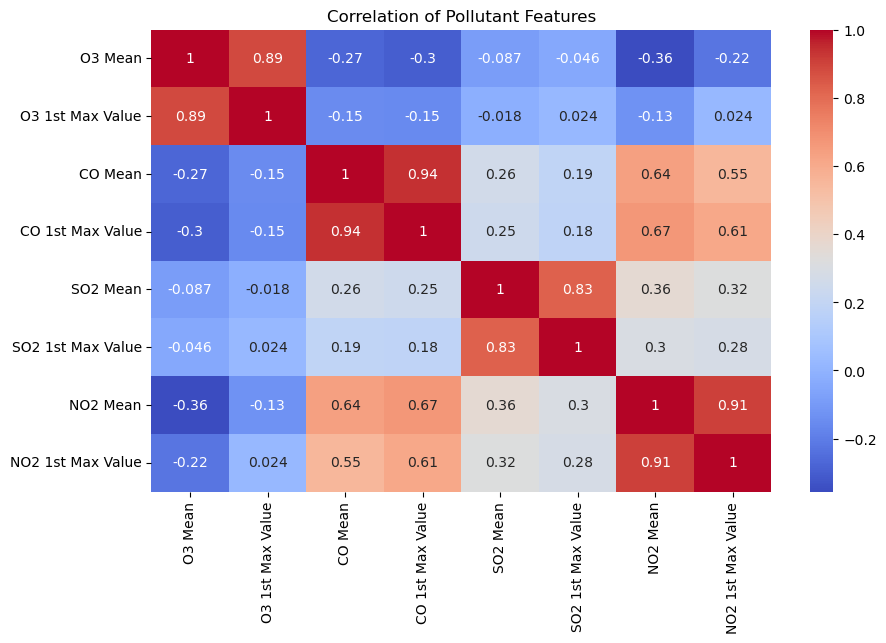

In [15]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pollution_dataset[scale_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Pollutant Features")
plt.show()

# Time trend of a pollutant in a major city
city_name = 'Los Angeles'
la_data = pollution_dataset[pollution_dataset['City'] == city_name]
fig = px.line(la_data, x='Date', y='O3 Mean', title=f'O3 Levels Over Time in {city_name}')
fig.show()